# imports

In [1]:
import pandas as pd
import scanpy as sc
import os
import numpy as np

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## **define niters*******

In [2]:
niters = 10000

# one time

## load data

In [68]:
if niters == 500:
    path_rED_results = 'niters500_validation_r_emptydrops_results.csv'
elif niters == 10000:
    path_rED_results = 'niters10000_validation_r_emptydrops_results.csv'

path_pyED_results = '../data/emptydrops_filtered_matrix_corrected.h5ad'
path_raw_data = '../data/raw_feature_bc_matrix.h5'

raw_data = sc.read_10x_h5(path_raw_data)
raw_data.var_names_make_unique()

raw_data_gex = sc.read_10x_h5(path_raw_data, gex_only=True)
raw_data_gex.var_names_make_unique()

rED_csv = pd.read_csv(path_rED_results, index_col=0)
print("CSV rED results shape:", rED_csv.shape)
print("Columns:", rED_csv.columns)

pyED_data = sc.read_h5ad(path_pyED_results)

CSV rED results shape: (722431, 5)
Columns: Index(['Total', 'LogProb', 'PValue', 'Limited', 'FDR'], dtype='object')


## analyze R results

In [69]:
print("RAW MATRIX")
print(raw_data_gex)
print("pyED RESULTS")
print(pyED_data)
print("rED RESULTS (.csv)")
print(rED_csv.shape)
print(rED_csv.columns)
print(rED_csv.head())

RAW MATRIX
AnnData object with n_obs × n_vars = 722431 × 22040
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
pyED RESULTS
AnnData object with n_obs × n_vars = 14997 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info'
rED RESULTS (.csv)
(722431, 5)
Index(['Total', 'LogProb', 'PValue', 'Limited', 'FDR'], dtype='object')
   Total  LogProb  PValue Limited  FDR
1      5      NaN     NaN     NaN  NaN
2      0      NaN     NaN     NaN  NaN
3     25      NaN     NaN     NaN  NaN
4     12      NaN     NaN     NaN  NaN
5      1      NaN     NaN     NaN  NaN


In [70]:
# First, get the barcodes that are marked as non-empty -> all cells in FDR != NaN
non_empty_barcodes = rED_csv[rED_csv['FDR'].notna()].index
print(f"in total there were {len(non_empty_barcodes)} cells tested against the ambient in rED .csv")
non_empty_below_FDR_005 = rED_csv[rED_csv['FDR'] < 0.05].index
print(f"called cells with < 0.05 FDR: {len(non_empty_below_FDR_005)}")
non_empty_below_FDR_001 = rED_csv[rED_csv['FDR'] < 0.01].index
print(f"called cells with < 0.01 FDR: {len(non_empty_below_FDR_001)}")
non_empty_below_FDR_0001 = rED_csv[rED_csv['FDR'] < 0.001].index
print(f"called cells with < 0.001 FDR: {len(non_empty_below_FDR_0001)}")

# save alle prints to a txt file
if niters == 500:
    with open('niters500_R_results.txt', 'w') as f:
        f.write(str(f"in total there were {len(non_empty_barcodes)} cells tested against the ambient in rED .csv"))
        f.write(str(f"\n\n called cells with < 0.05 FDR: {len(non_empty_below_FDR_005)}"))
        f.write(str(f"\n called cells with < 0.01 FDR: {len(non_empty_below_FDR_001)}"))
        f.write(str(f"\n called cells with < 0.001 FDR: {len(non_empty_below_FDR_0001)}"))
elif niters == 10000:
    with open('niters10000_R_results.txt', 'w') as f:
        f.write(str(f"in total there were {len(non_empty_barcodes)} cells tested against the ambient in rED .csv"))
        f.write(str(f"\n\n called cells with < 0.05 FDR: {len(non_empty_below_FDR_005)}"))
        f.write(str(f"\n called cells with < 0.01 FDR: {len(non_empty_below_FDR_001)}"))
        f.write(str(f"\n called cells with < 0.001 FDR: {len(non_empty_below_FDR_0001)}"))

in total there were 15000 cells tested against the ambient in rED .csv
called cells with < 0.05 FDR: 8212
called cells with < 0.01 FDR: 7509
called cells with < 0.001 FDR: 6902


## map csv to h5ad

In [71]:
raw_data_gex.X

<722431x22040 sparse matrix of type '<class 'numpy.float32'>'
	with 18590407 stored elements in Compressed Sparse Row format>

In [72]:
non_empty_below_FDR_005

Index([   100,    266,    307,    379,    422,    502,    866,    887,   1132,
         1187,
       ...
       721801, 721855, 721923, 722001, 722048, 722151, 722258, 722280, 722334,
       722344],
      dtype='int64', length=8212)

In [73]:
# non_empty_below_FDR_005 (index) map to raw_data
rED_h5ad = raw_data_gex[non_empty_below_FDR_005-1, :]
print(rED_h5ad.X.shape)
rED_h5ad.X

(8212, 22040)


<8212x22040 sparse matrix of type '<class 'numpy.float32'>'
	with 12611865 stored elements in Compressed Sparse Row format>

In [74]:
rED_h5ad_test = raw_data_gex[non_empty_barcodes-1, :]
rED_h5ad_total_counts = np.array(rED_h5ad_test.X.sum(axis=1)).flatten()
print(rED_h5ad_total_counts.sum())

lower = 100
raw_below_lower = raw_data_gex[raw_data_gex.X.sum(axis=1) > lower, :]
raw_below_lower_total_counts = np.array(raw_below_lower.X.sum(axis=1)).flatten()
print(raw_below_lower_total_counts.sum())

# check if the total counts are the same
print((rED_h5ad_total_counts == raw_below_lower_total_counts).sum()) #only 2 cells have total counts in common, might be luck. rest is different -> suggests that mapping is not correct.

30993260.0
30993260.0
15000


## !!important 
so we just needed to map the indices correctly by doing -1 to the indices since python stars from 1

In [75]:
# save rED_h5ad
if niters == 500:
    rED_h5ad.write_h5ad('niters500_rED_results.h5ad', compression='gzip')
    rED_h5ad.write_h5ad('../data/niters500_rED_results.h5ad', compression='gzip')
elif niters == 10000:
    rED_h5ad.write_h5ad('niters10000_rED_results.h5ad', compression='gzip')
    rED_h5ad.write_h5ad('../data/niters10000_rED_results.h5ad', compression='gzip')

# GSEA of rED

Output directory created: niters10000_GSEA_rED/GSEA_20251022_194420
Defined 29 trajectory markers of germ cells (5 categories)
Cell type markers: 62 total including leydig/sertoli etc
Original data shape: (8212, 22040)
Data loaded and QC metrics calculated


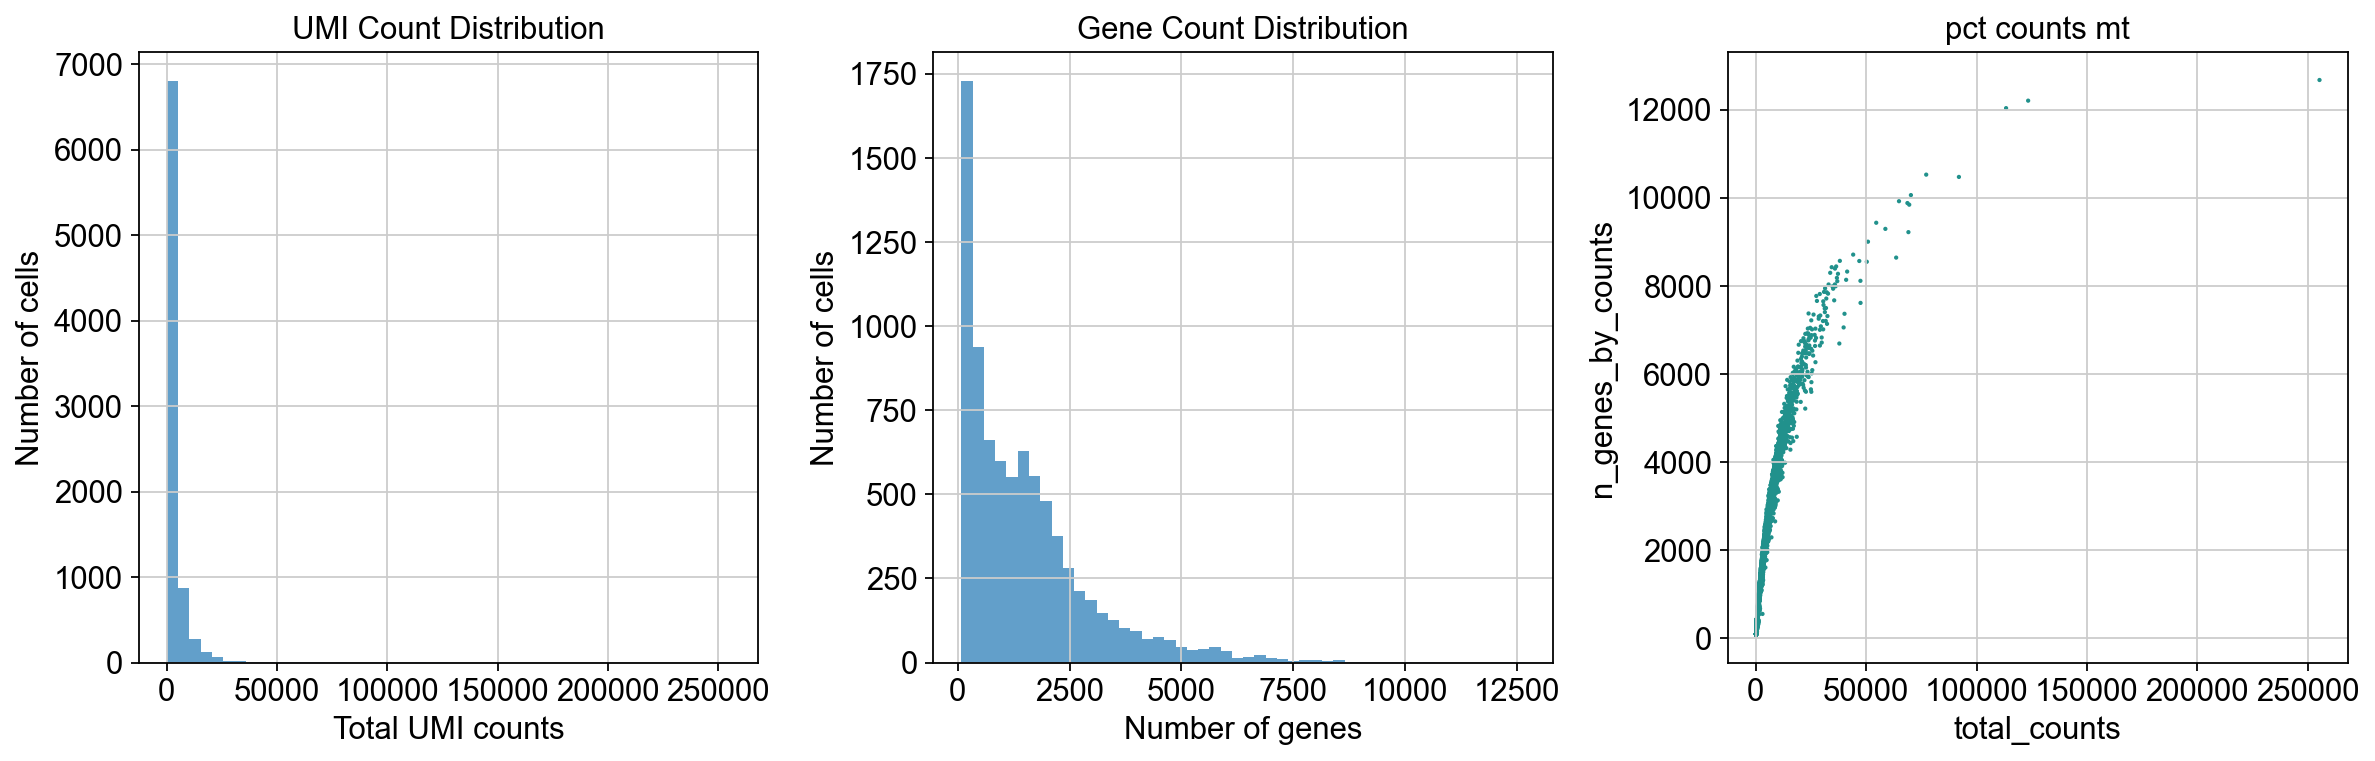


NORMALIZATION & SCALING
Parameters saved to: niters10000_GSEA_rED/GSEA_20251022_194420/parameters.txt
Custom hvg parameters: 0.01, 8, 0.3, 3000
Highly variable genes: 3000
In data available spermatogenesis markers: 26/29
Markers not found in data: {'SOHLH1', 'UTF1', 'DMRT6'}
HVG spermatogenesis markers: 5
Top 12 HVG: ['TEX101', 'TNP1', 'CRISP2', 'PRM1', 'OAZ3']

ADVANCED DIMENSIONALITY REDUCTION


Compute diffusion-based UMAP: 100%|██████████| 4/4 [00:40<00:00, 10.10s/step]



SPERMATOGENESIS TRAJECTORY INFERENCE
Root cluster set: 14

GSEA PATHWAY ANALYSIS
Progression groups: progression_group
LATE     4173
EARLY    4039
Name: count, dtype: int64
(1/1) Running GSEA with GO_Biological_Process_2023...
   -> 2438 pathways found

TOP PATHWAYS (first database):
                                                Term        ES       NES  \
0       Peptidyl-Serine Phosphorylation (GO:0018105) -0.598297 -2.586441   
1      Regulation Of Hydrolase Activity (GO:0051336) -0.610691 -2.559786   
2  Positive Regulation Of GTPase Activity (GO:004... -0.547458 -2.555436   
3       Ras Protein Signal Transduction (GO:0007265) -0.591256 -2.554877   
4             Cellular Response To cAMP (GO:0071320) -0.727941 -2.546286   
5                  Response To Cytokine (GO:0034097) -0.592288  -2.54168   
6         Regulation Of GTPase Activity (GO:0043087) -0.550261 -2.539763   
7          Peptidyl-Serine Modification (GO:0018209)  -0.58576 -2.538733   
8  Cellular Response To Organi

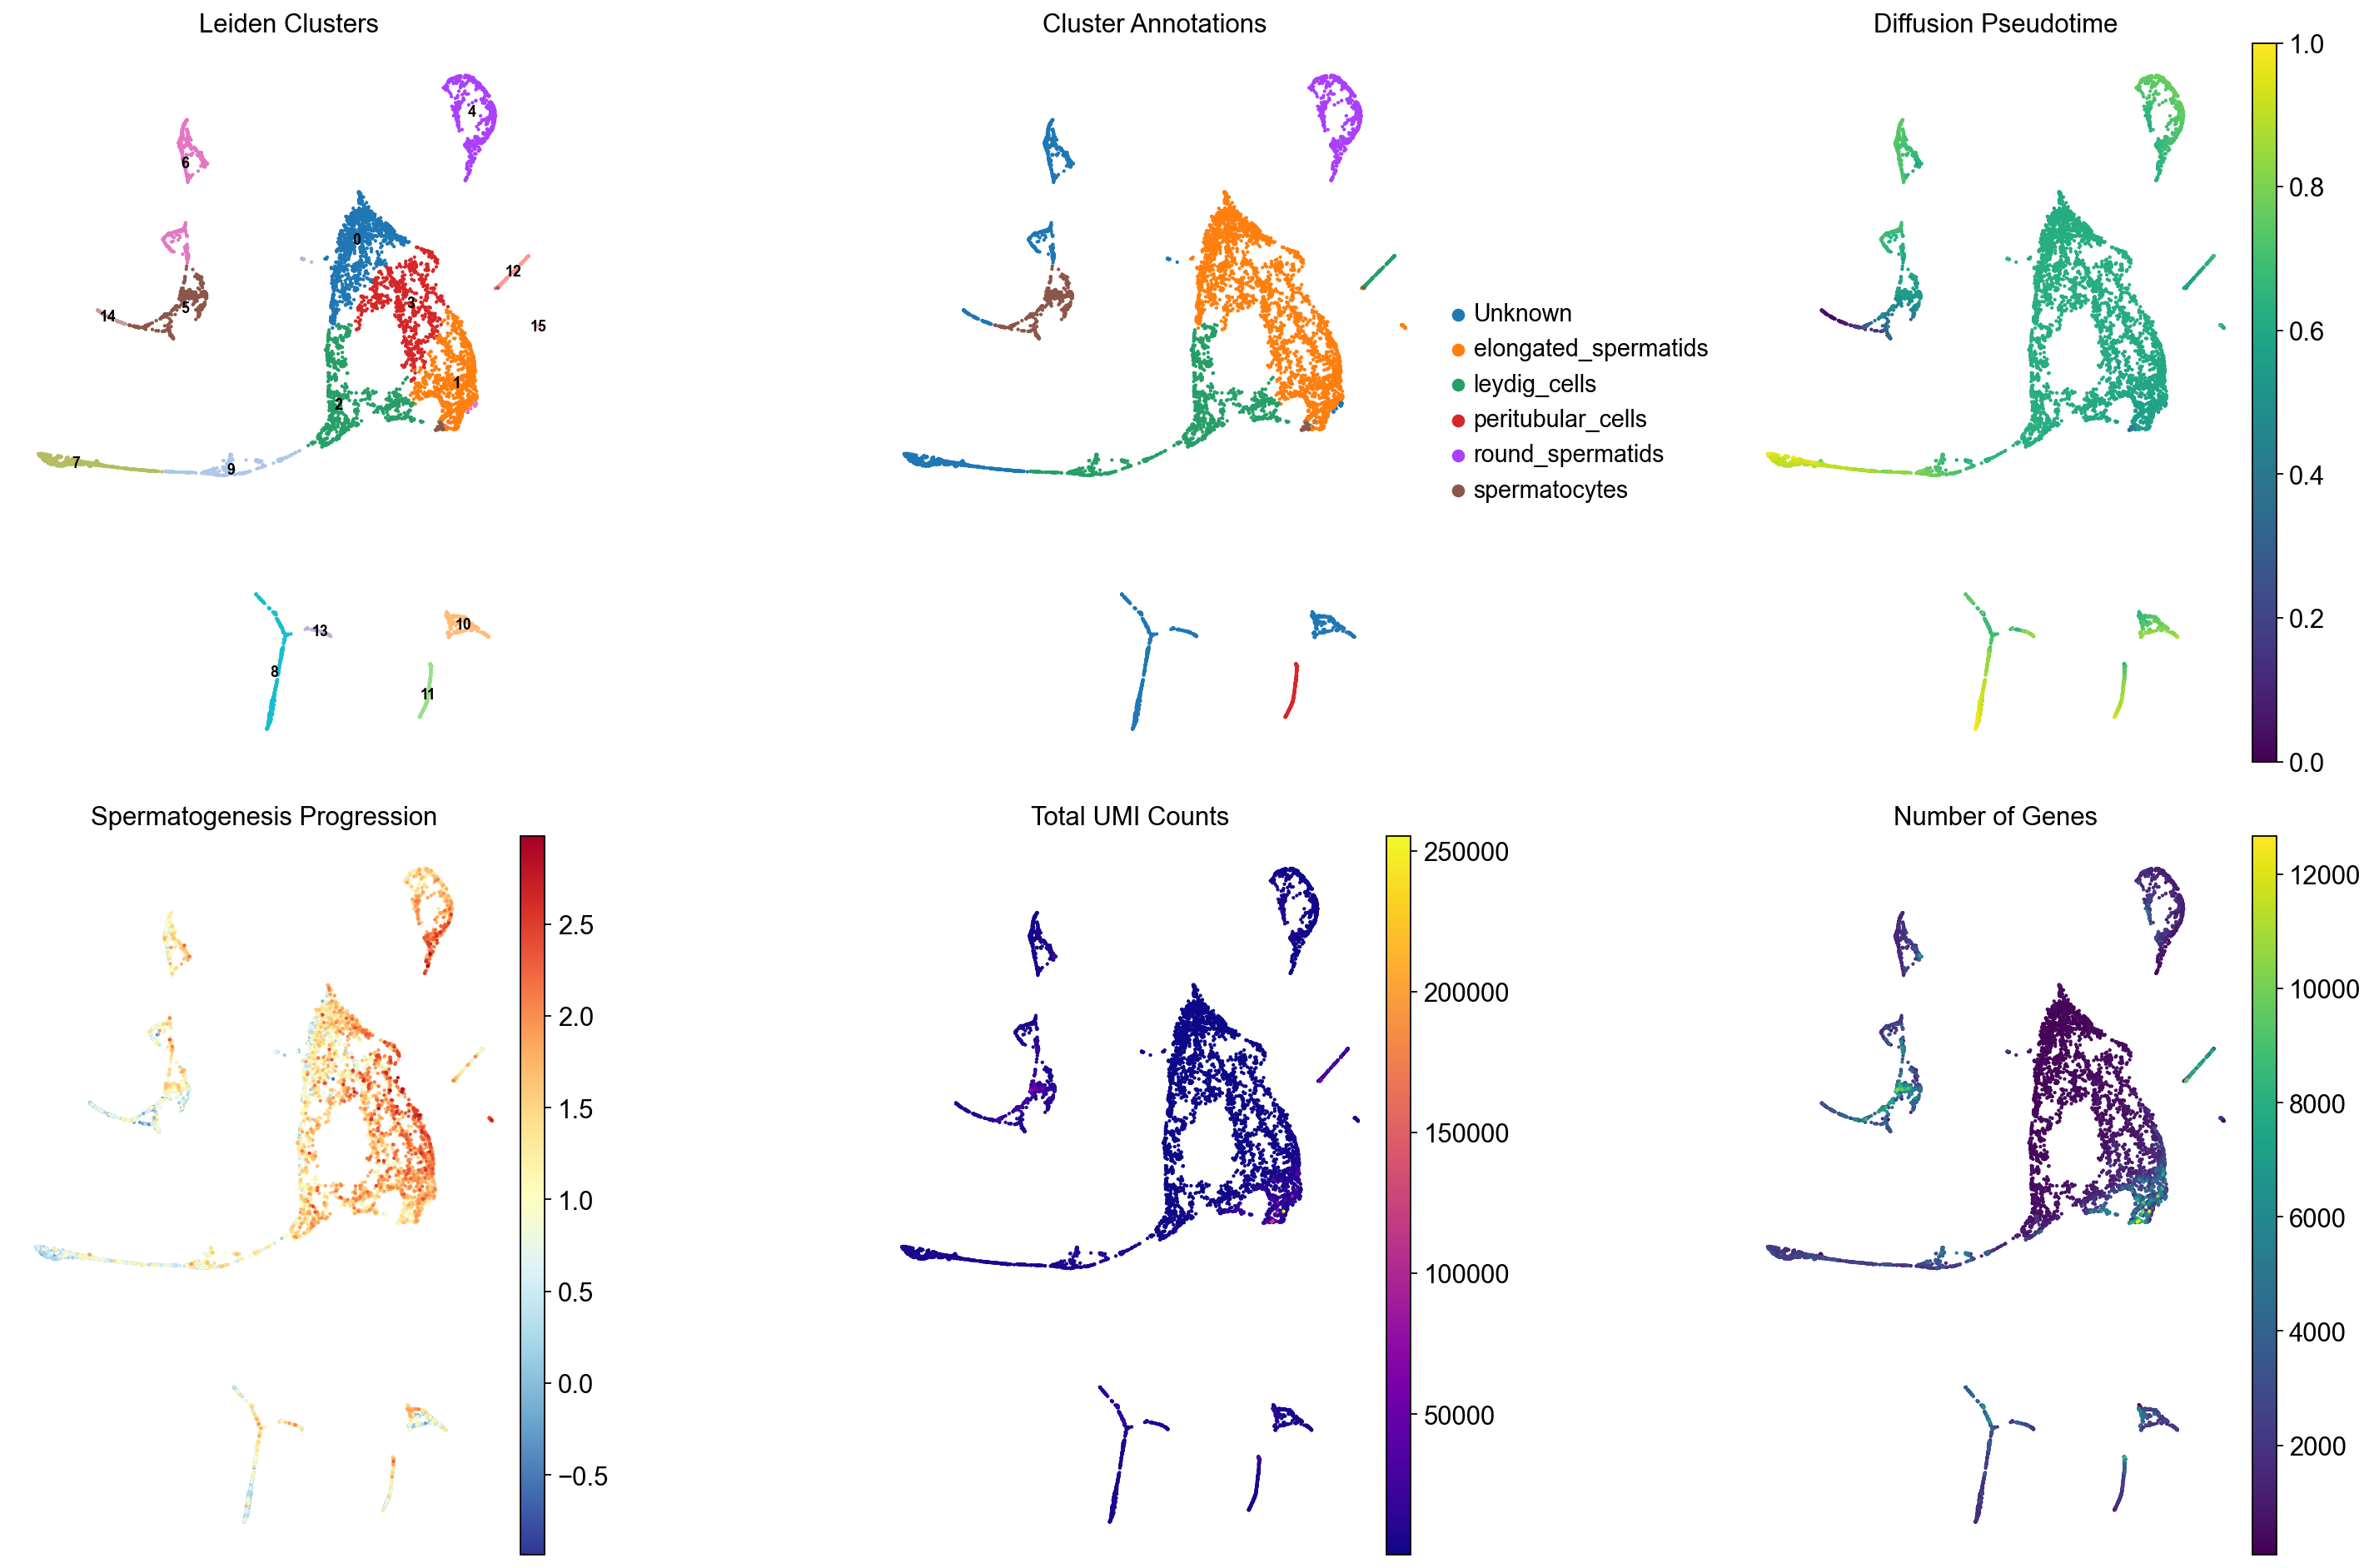


Creating cluster-specific marker plots...


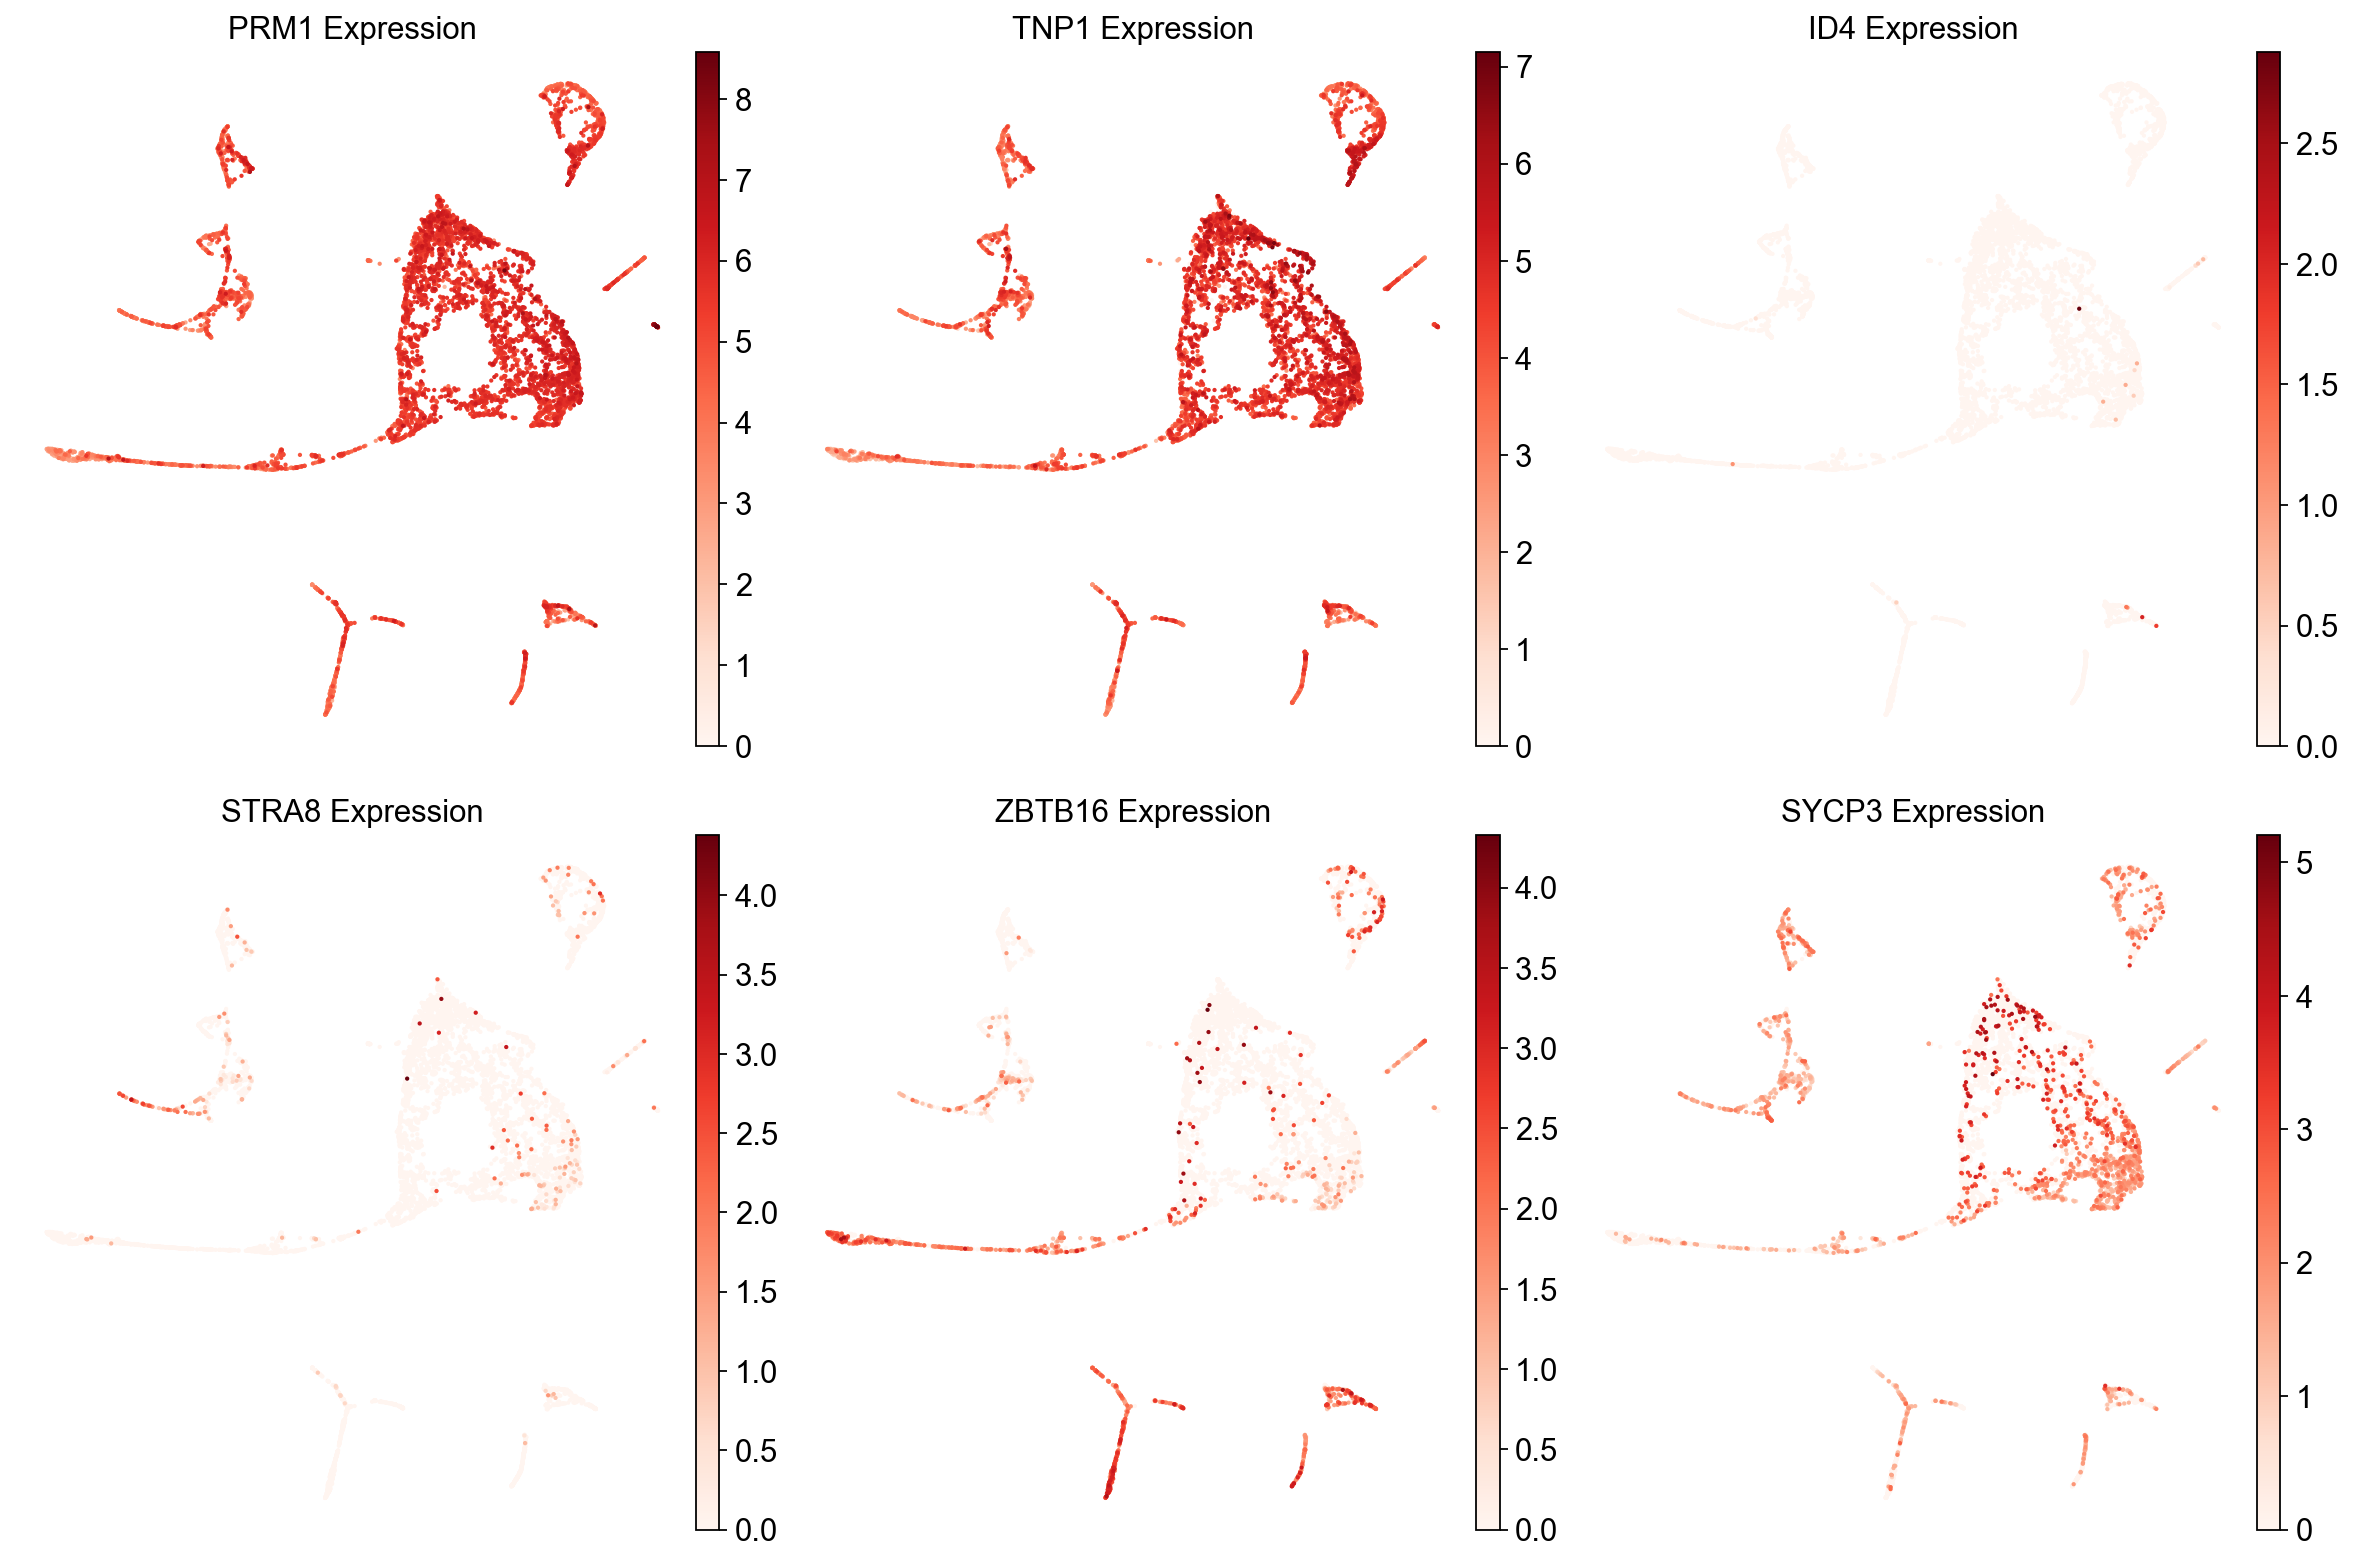

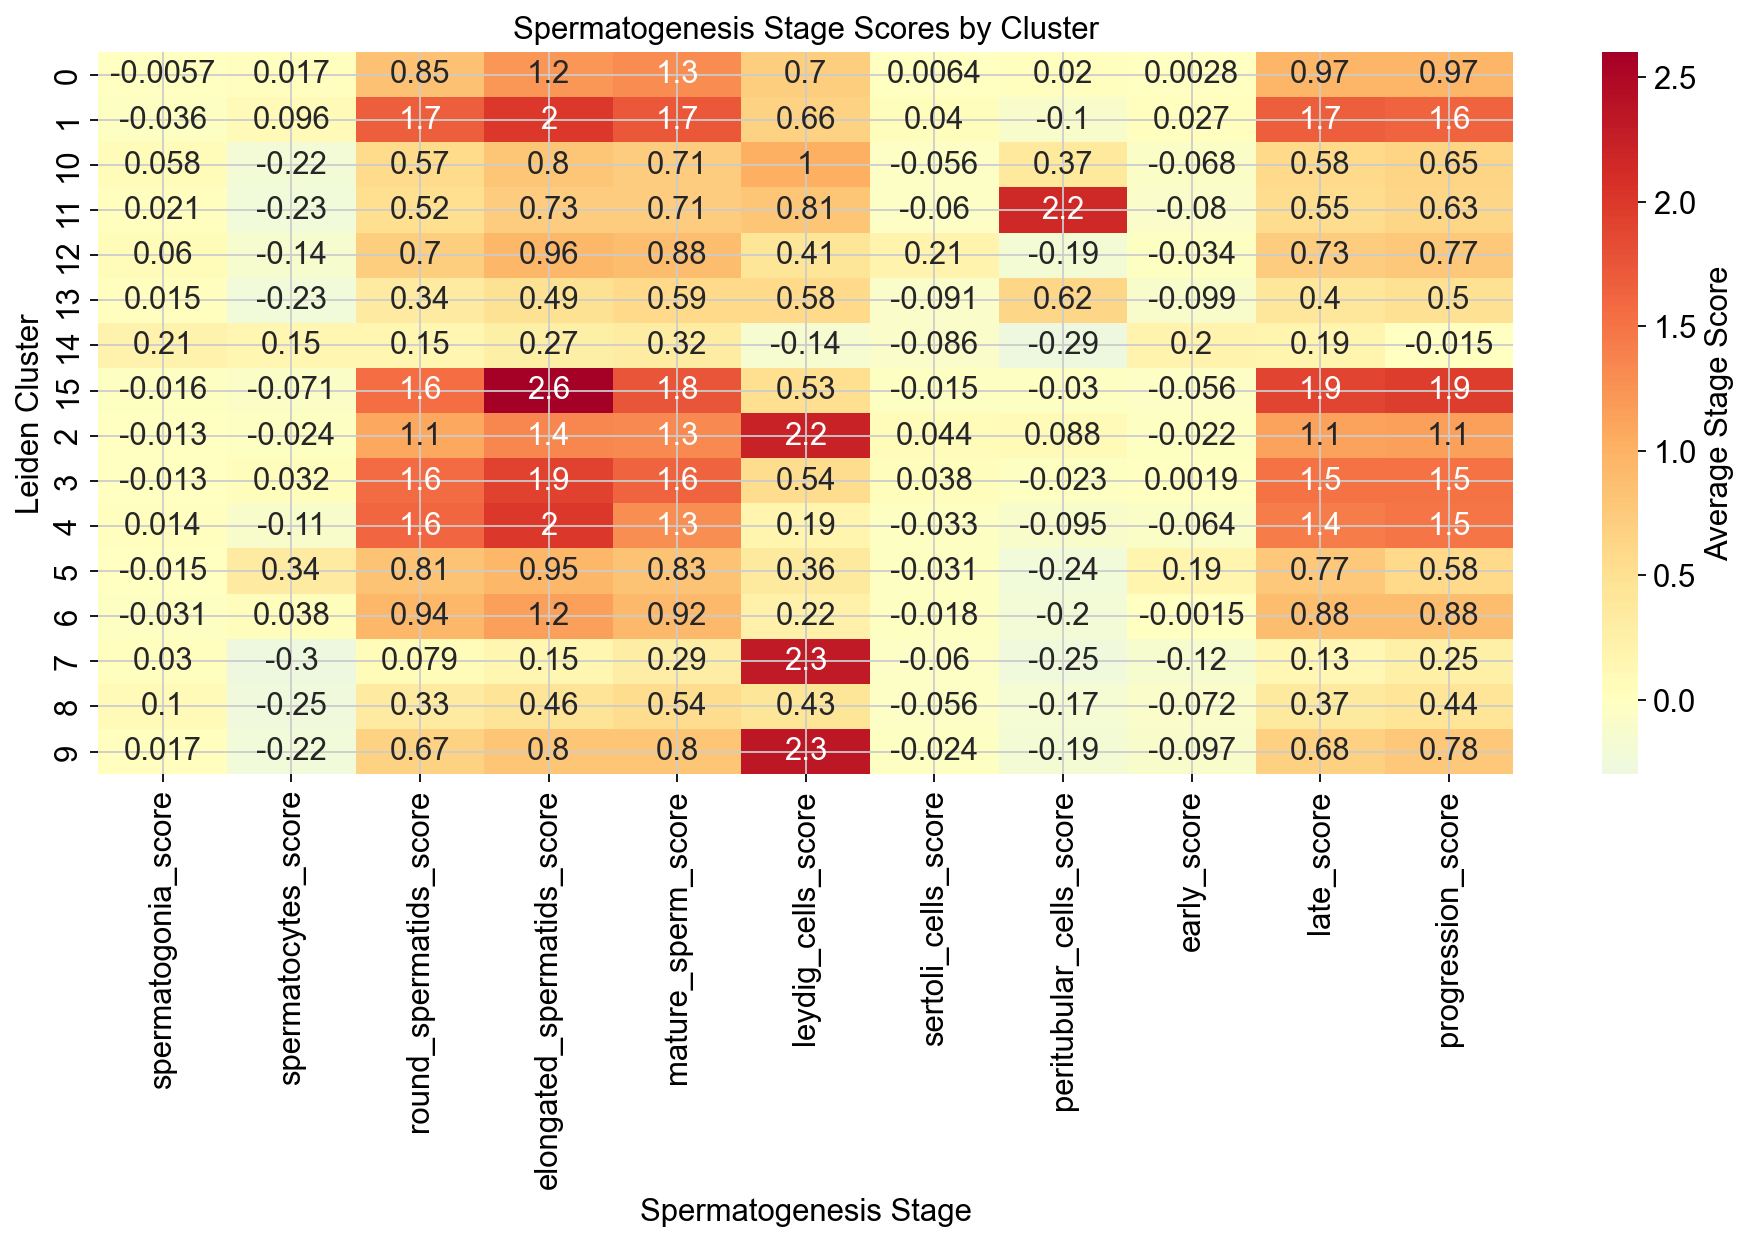

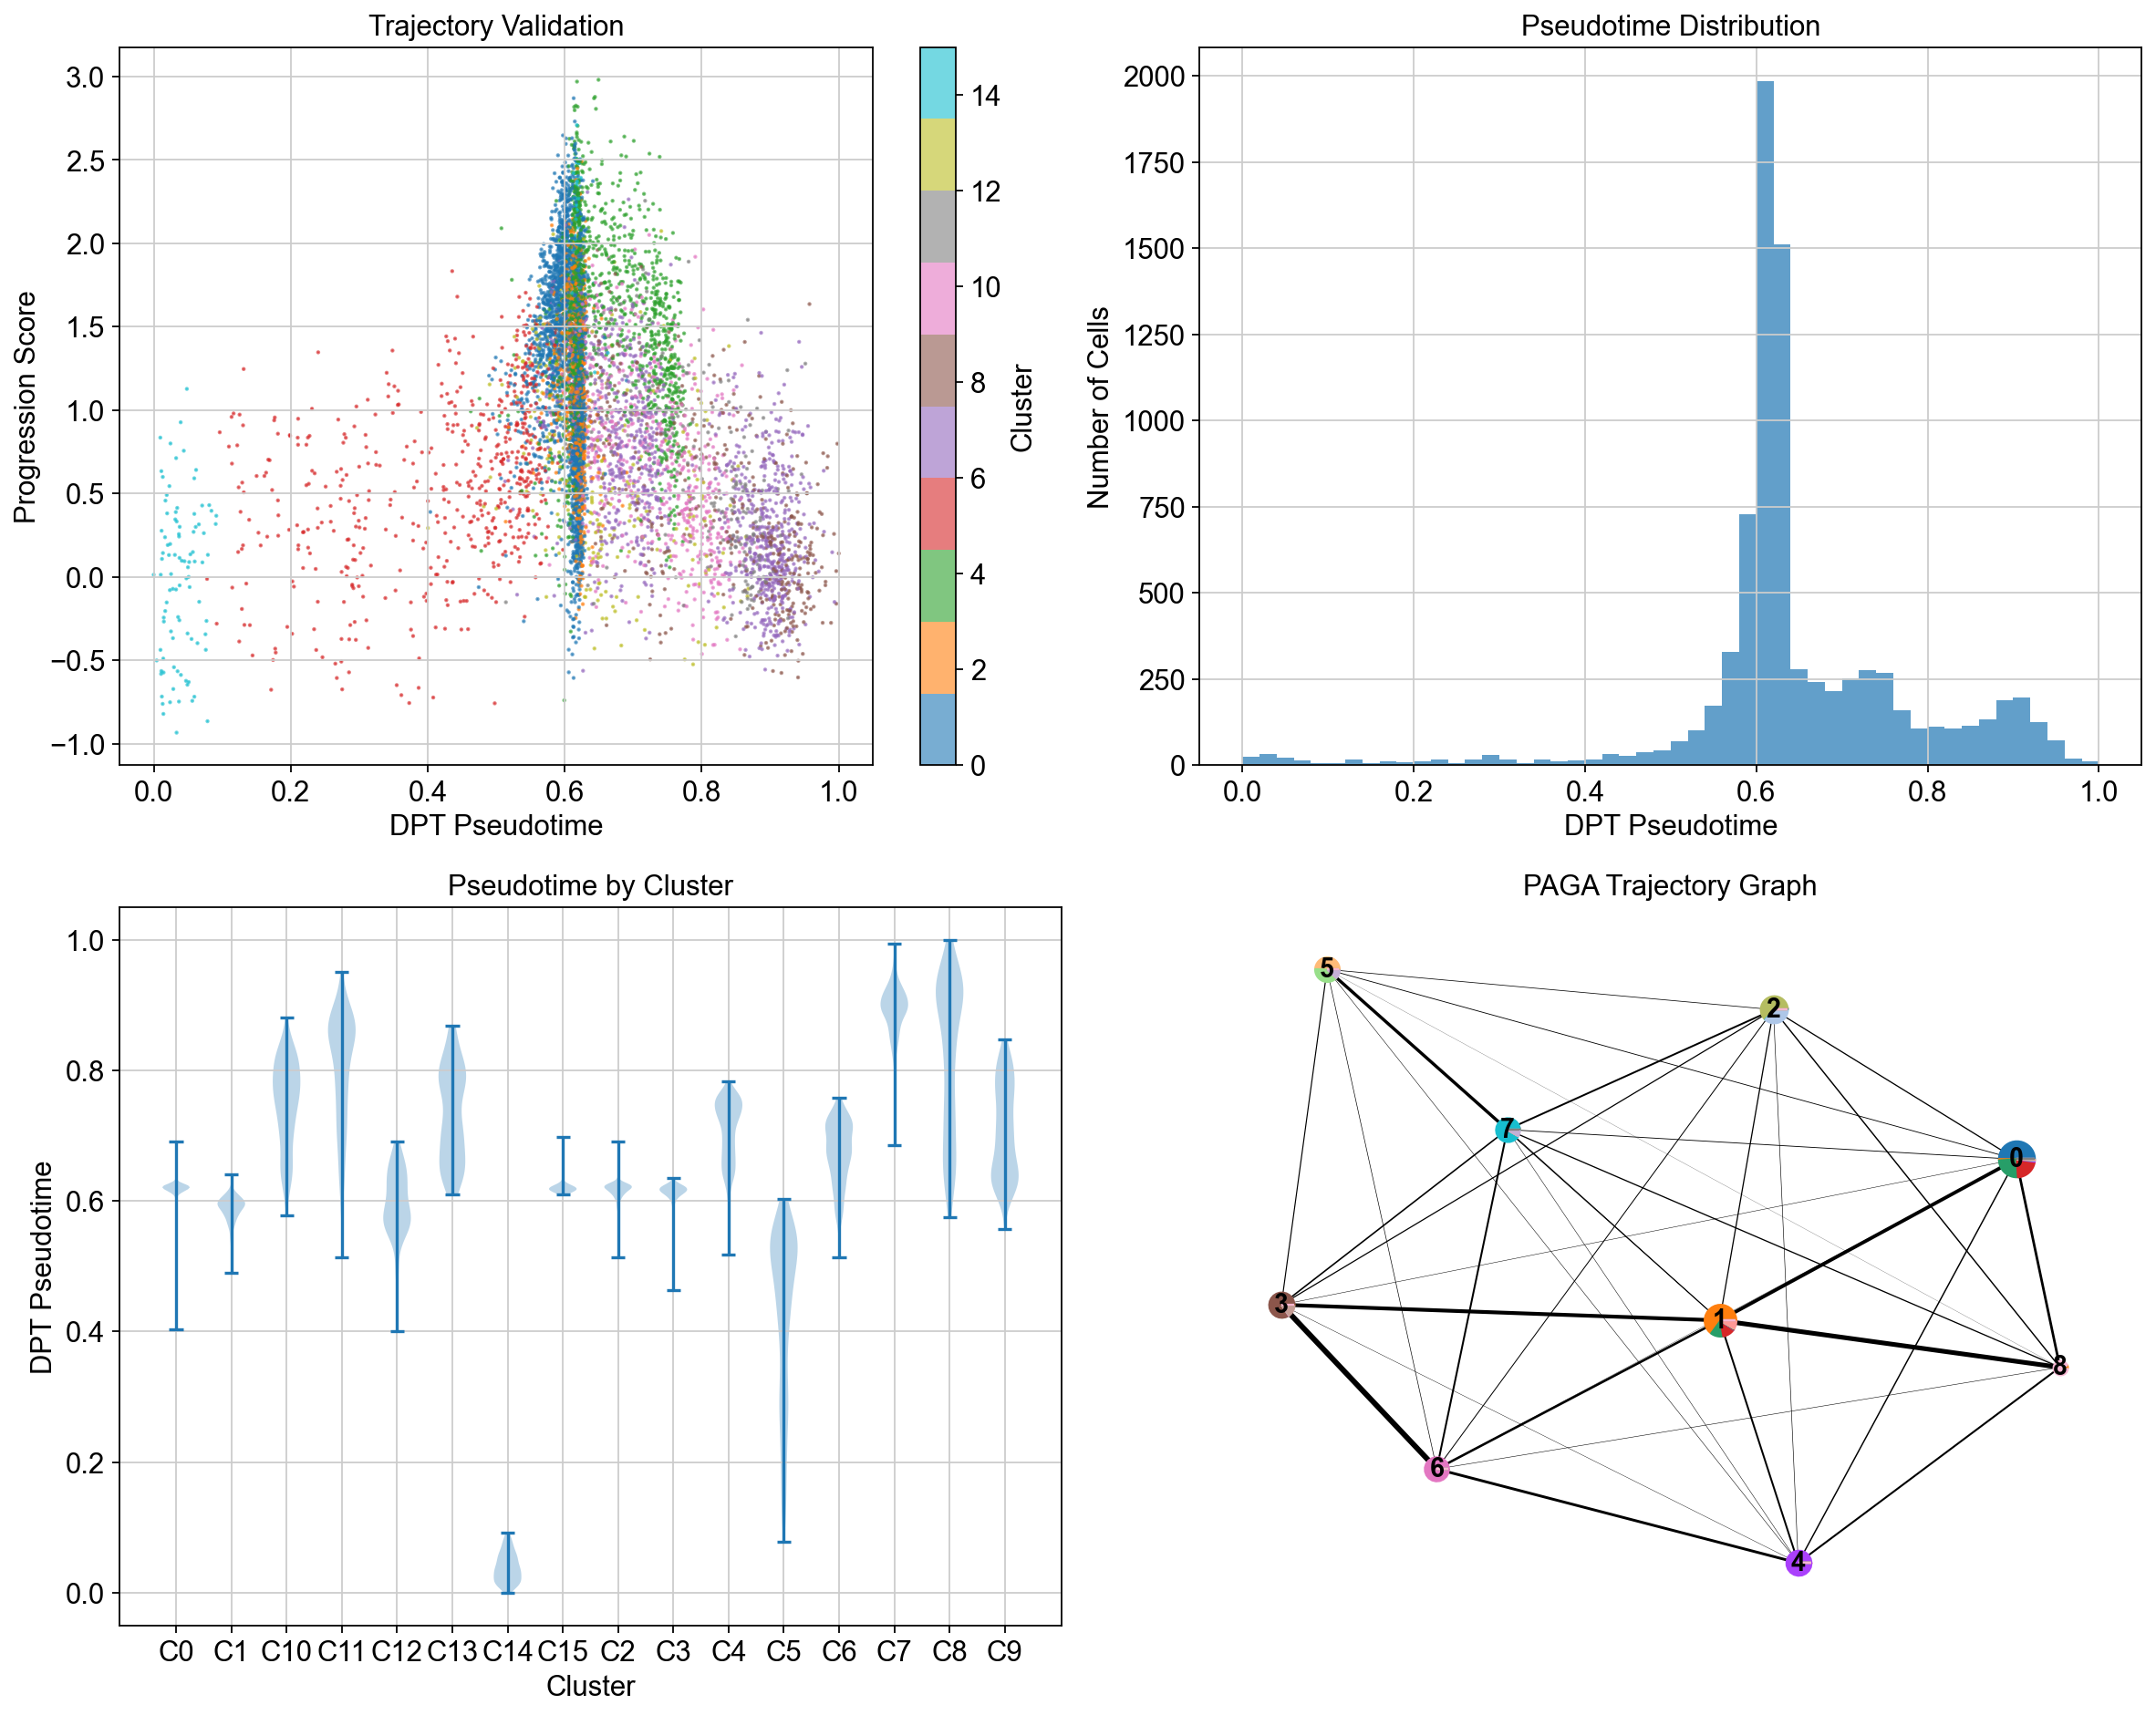


ANALYSIS SUMMARY
Final data: 8212 cells × 3021 features
Clusters identified: 16
Annotated clusters: 16
Pseudotime range: 0.000 - 1.000
GSEA databases: 1


In [3]:
import sys
sys.path.insert(1, '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/GSEA_new')
from gene_pathway_analysis import SpermatogenesisAnalyzer

if niters == 500:
    data_path = 'niters500_rED_results.h5ad'
    output_dir = 'niters500_GSEA_rED'
elif niters == 10000:
    data_path = 'niters10000_rED_results.h5ad'
    output_dir = 'niters10000_GSEA_rED'

SA = SpermatogenesisAnalyzer(data_path=data_path,
                             output_dir=output_dir,
                             activate_advanced_filtering=False,
                             activate_hvg=True)
rdata = SA.run_complete_analysis()

# normal UMAP rED

Original shape: (8031, 22040)
Final shape: (8031, 22040)
Generated UMAP with minimal preprocessing


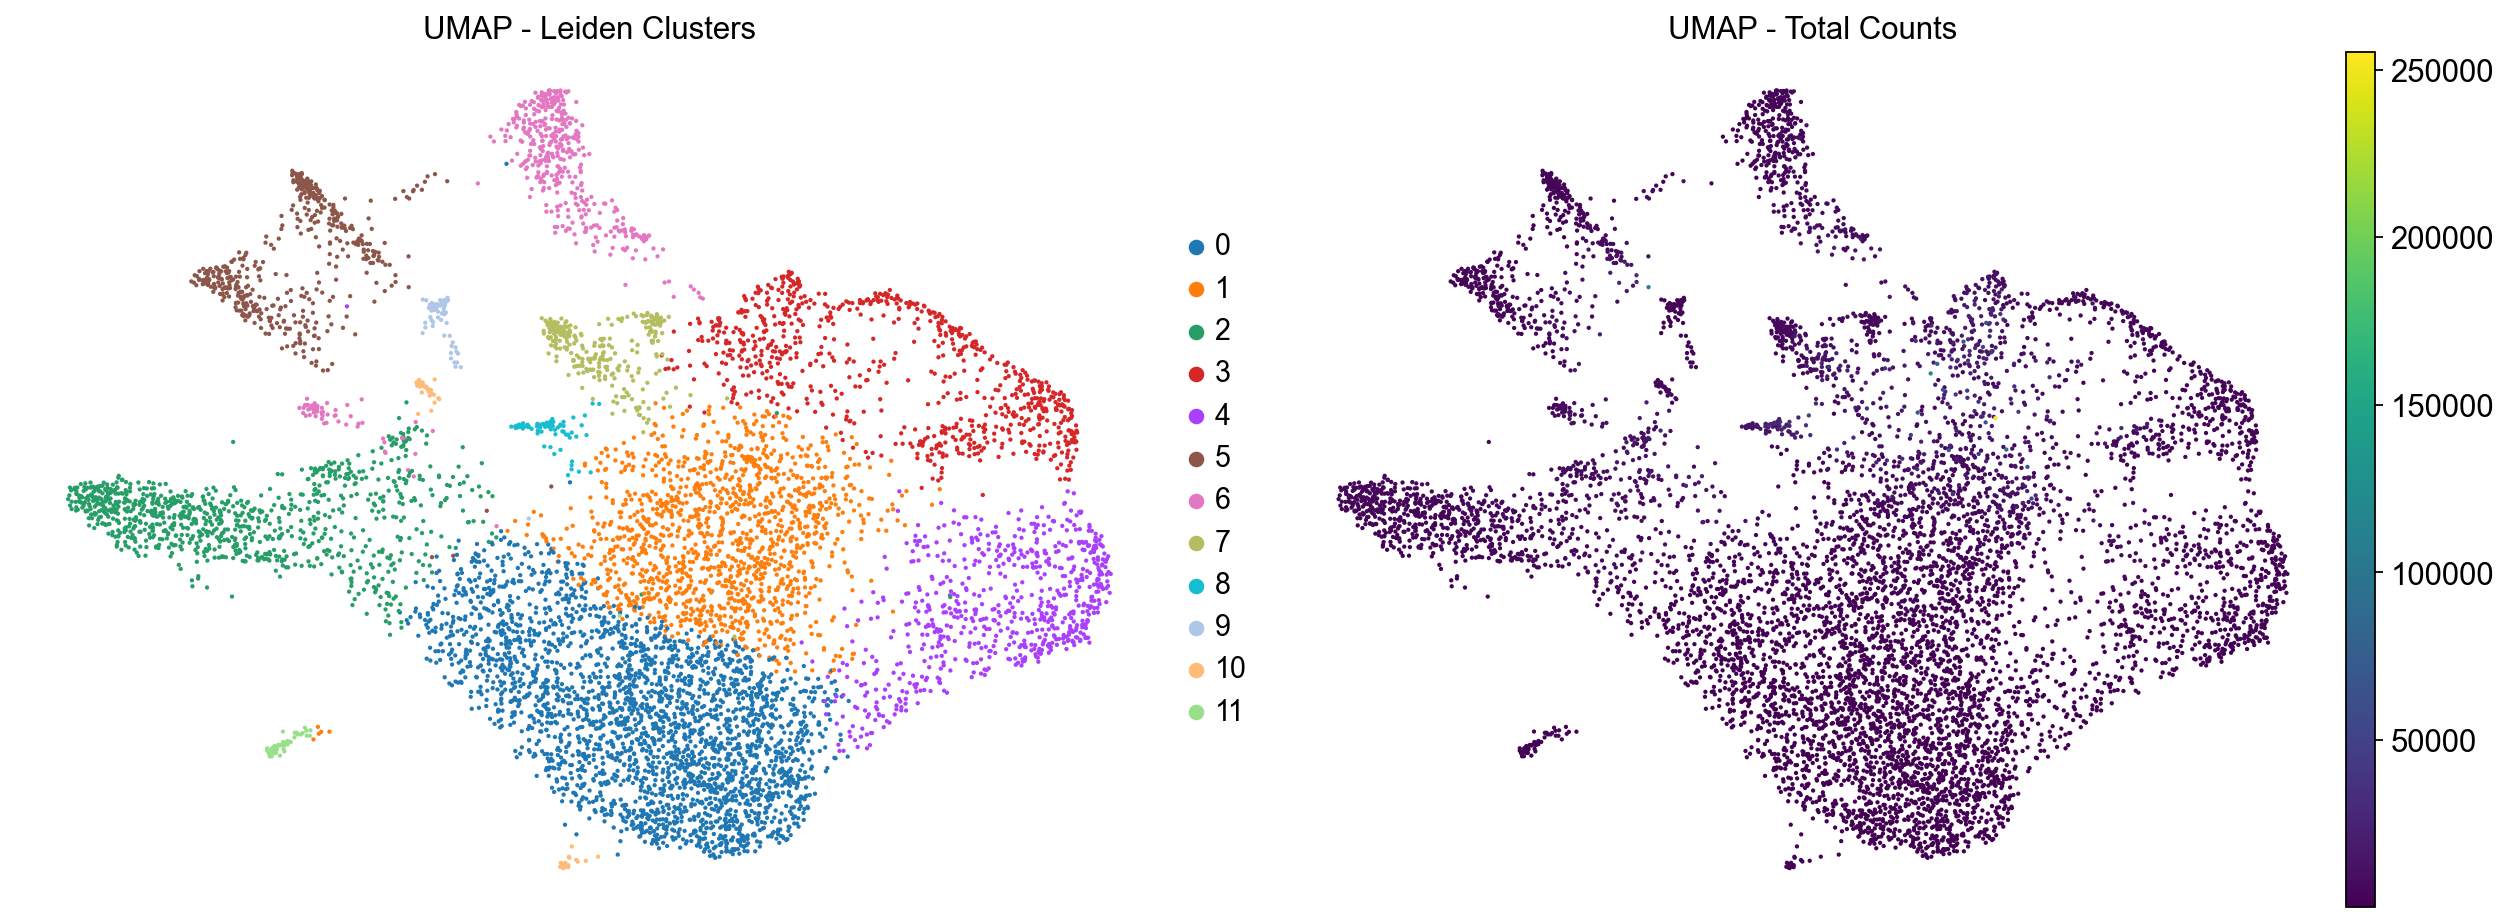


CLUSTER MARKER IDENTIFICATION
Cluster 1: ['GSTM3', 'RPLP0', 'ENSSSCG00000028485', 'CRISP2', 'HSPB9']
   -> 1396 cells
Cluster 3: ['SDCCAG8', 'SPAG16', 'FSIP2', 'DIAPH3', 'VPS13A']
   -> 784 cells
Cluster 0: ['PRM1', 'COX1', 'GNLY', 'CD8A', 'KLRK1']
   -> 2723 cells
Cluster 2: ['SULT1C3', 'FRS2', 'RDH12', 'AKR1C8', 'GREB1L']
   -> 961 cells
Cluster 4: ['ARFGEF3', 'PPP2R2B', 'SLC4A10', 'SPATA16', 'RILPL1']
   -> 714 cells
Cluster 6: ['PTPRM', 'TMSB4X', 'ENSSSCG00000033894', 'LDB2', 'TCF4']
   -> 461 cells
Cluster 5: ['RBMS3', 'ENSSSCG00000001427', 'PRKG1', 'ARHGAP28', 'DCN']
   -> 482 cells
Cluster 7: ['AUTS2', 'DOCK3', 'HPSE2', 'SMC1B', 'EEA1']
   -> 265 cells
Cluster 10: ['FOXP1', 'MED13L', 'ELMO1', 'MEF2C', 'DIAPH2']
   -> 53 cells
Cluster 9: ['DLC1', 'PRKG1', 'IGFBP7', 'TPM1', 'EBF1']
   -> 64 cells
Cluster 11: ['ENSSSCG00000048990', 'OAZ3', 'ENSSSCG00000038037', 'HSPB9', 'TSPAN6']
   -> 52 cells
Cluster 8: ['ERBB4', 'AUTS2', 'ADGRB3', 'KIAA1217', 'PWWP3B']
   -> 76 cells


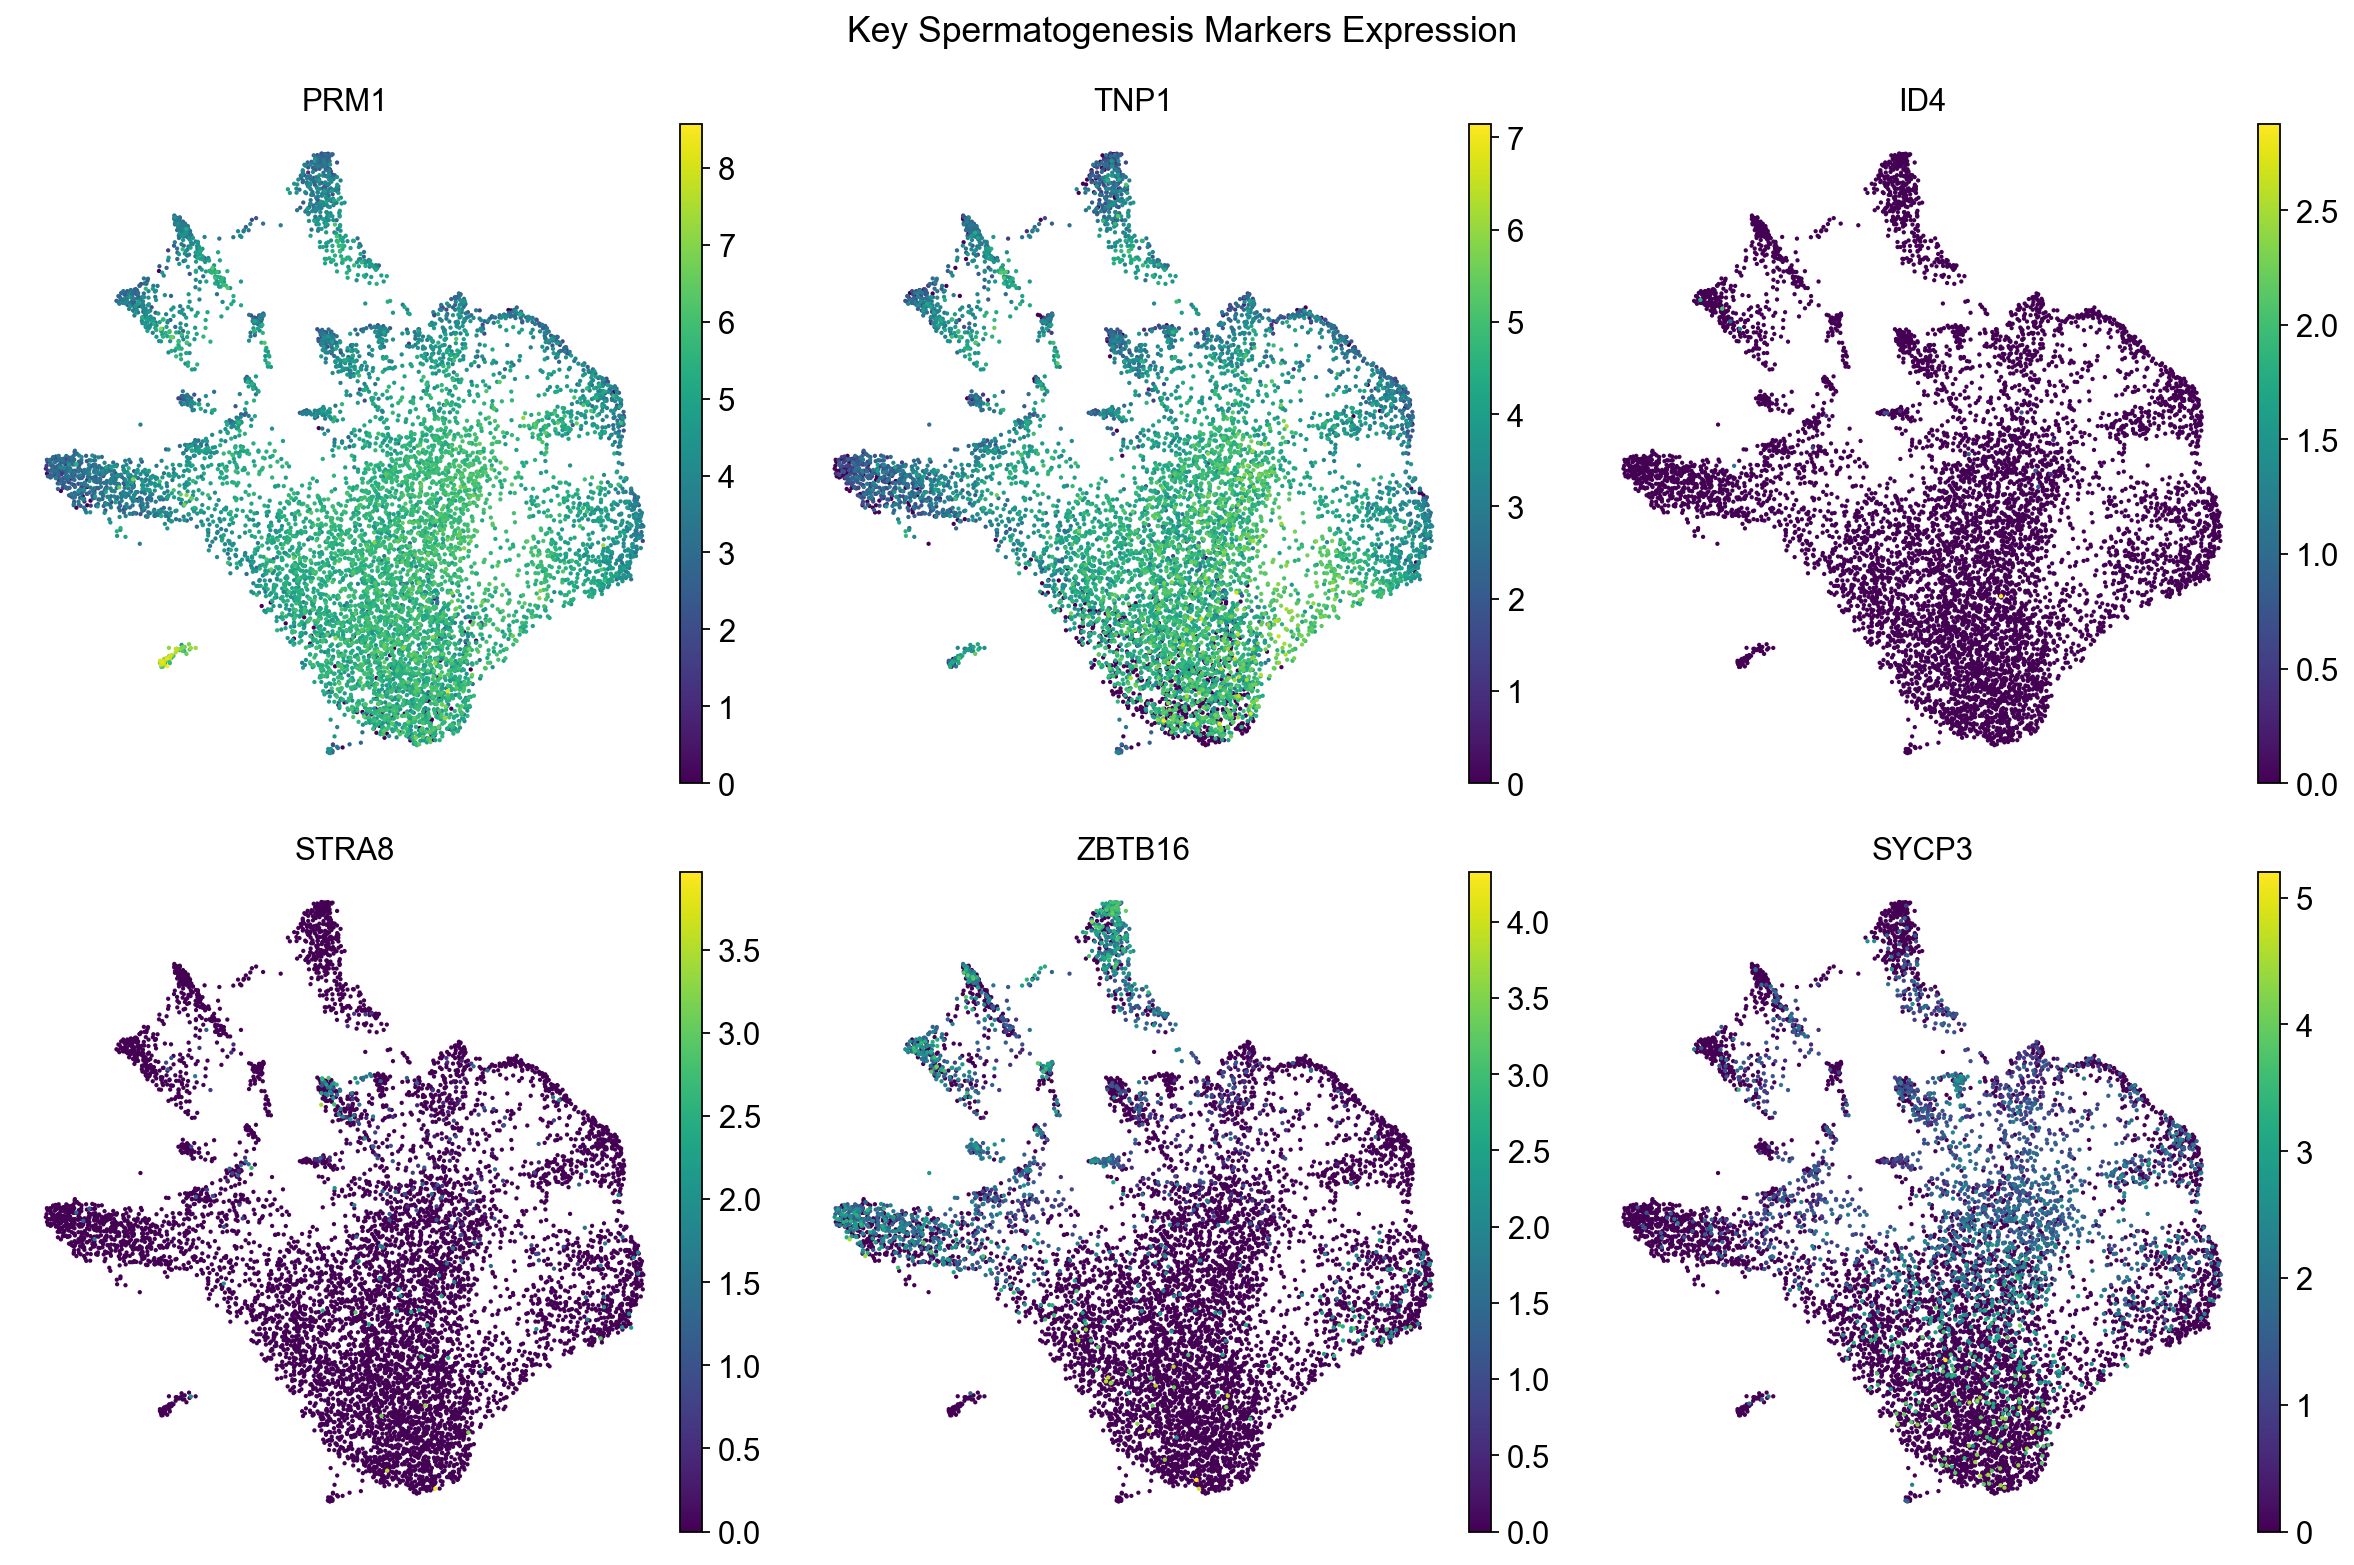

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
# Simple UMAP for CellBender data - minimal preprocessing
simple_adata = sc.read_h5ad('niters500_rED_results.h5ad')

print(f"Original shape: {simple_adata.shape}")

# Minimal QC - just remove obvious empty cells
sc.pp.calculate_qc_metrics(simple_adata, inplace=True)

# Very basic filtering (optional - comment out if you want truly raw)
sc.pp.filter_cells(simple_adata, min_genes=4)
#sc.pp.filter_genes(simple_adata, min_cells=3)

# Basic normalization
sc.pp.normalize_total(simple_adata, target_sum=1e4)
sc.pp.log1p(simple_adata)

# Use all genes or top variable genes (uncomment one approach)
# Option 1: Use ALL genes
#sc.pp.pca(simple_adata, n_comps=100)

# Option 2: Select HVGs (less aggressive than your pipeline)
sc.pp.highly_variable_genes(simple_adata, n_top_genes=3000)
# Increase n_comps for better capture of biological variation
sc.pp.pca(simple_adata, n_comps=70)

# Generate UMAP with parameters optimized for germ line visualization
# Higher n_neighbors for smoother manifold and better trajectory preservation
# More PCs to capture developmental gradients
# Lower min_dist for tighter clusters while preserving trajectory structure
sc.pp.neighbors(simple_adata, n_neighbors=50, n_pcs=30)
sc.tl.umap(simple_adata, min_dist=0.3, spread=1.0)

# Optional: add leiden clustering for coloring with HIGHER resolution for more clusters
sc.tl.leiden(simple_adata, resolution=0.4)  # Increased for more clusters

print(f"Final shape: {simple_adata.shape}")
print(f"Generated UMAP with minimal preprocessing")

# Visualize simple UMAP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Color by leiden clusters
sc.pl.umap(simple_adata, color='leiden', ax=axes[0], show=False, title='UMAP - Leiden Clusters')

# Color by total counts (QC metric)
sc.pl.umap(simple_adata, color='total_counts', ax=axes[1], show=False, title='UMAP - Total Counts')

plt.tight_layout()
plt.show()

# Find markers for each cluster and plot top genes
print(f"\nCLUSTER MARKER IDENTIFICATION")

# Find markers for each cluster
sc.tl.rank_genes_groups(
    simple_adata, 
    groupby='leiden', 
    method='t-test',
    n_genes=50,
    use_raw=False
)

# Get marker results
marker_df = sc.get.rank_genes_groups_df(simple_adata, group=None)

# Annotate clusters based on top markers
cluster_annotations = {}
top_markers_per_cluster = {}

for cluster in simple_adata.obs['leiden'].unique():
    cluster_markers = marker_df[
        (marker_df['group'] == cluster) & 
        (marker_df['pvals_adj'] < 0.05) &
        (marker_df['logfoldchanges'] > 0.5)
    ]['names'].head(10).tolist()

    top_markers_per_cluster[cluster] = cluster_markers
    
    count = (simple_adata.obs['leiden'] == cluster).sum()
    print(f"Cluster {cluster}: {cluster_markers[:5]}\n   -> {count} cells")

# Plot key spermatogenesis markers
key_markers = ['PRM1', 'TNP1', 'ID4', 'STRA8', 'ZBTB16', 'SYCP3']
n_markers = len(key_markers)

# Create a figure with subplots for all key markers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, marker in enumerate(key_markers):
    # Check if gene is available in the data
    if marker in simple_adata.var_names:
        sc.pl.umap(simple_adata, color=marker, ax=axes[i], show=False, 
                  title=f'{marker}')
    else:
        # If marker not available, show empty plot with message
        axes[i].text(0.5, 0.5, f'{marker}\n(not found)', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12)
        axes[i].set_title(f'{marker} (not found)')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        print(f"Warning: {marker} not found in data")

plt.suptitle('Key Spermatogenesis Markers Expression', fontsize=16)
plt.tight_layout()
plt.show()

## plot BARCODES

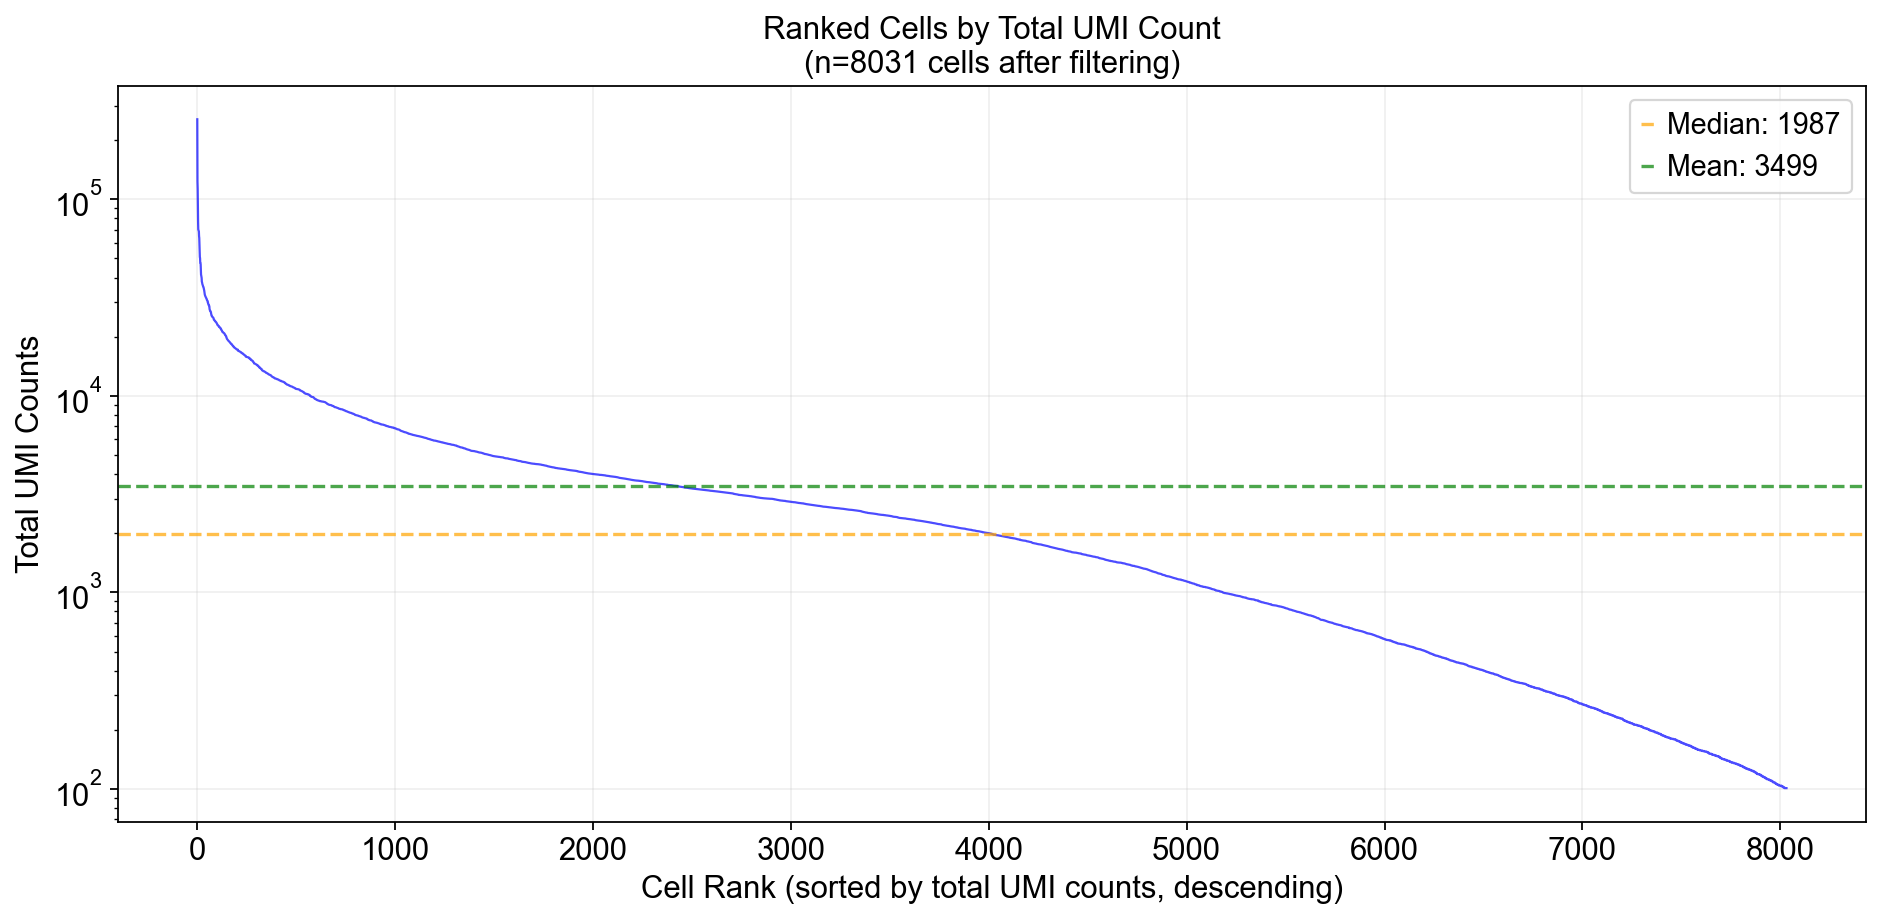

Total cells after filtering: 8031
UMI count statistics:
  Min: 101
  Max: 255392
  Mean: 3499


In [ ]:

# Plot ranked cells by total UMI count after filtering
# Calculate total UMI counts per cell
if 'total_counts' in simple_adata.obs.columns:
    total_counts = simple_adata.obs['total_counts'].values
else:
    total_counts = np.array(simple_adata.X.sum(axis=1)).flatten()

# Sort cells by total UMI count in descending order
sorted_indices = np.argsort(total_counts)[::-1]
sorted_counts = total_counts[sorted_indices]
cell_ranks = np.arange(1, len(sorted_counts) + 1)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot: Full range
ax.plot(cell_ranks, sorted_counts, 'b-', alpha=0.7, linewidth=1)
ax.set_xlabel('Cell Rank (sorted by total UMI counts, descending)')
ax.set_ylabel('Total UMI Counts')
ax.set_title(f'Ranked Cells by Total UMI Count\n(n={len(sorted_counts)} cells after filtering)')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Add some statistics
median_counts = np.median(sorted_counts)
mean_counts = np.mean(sorted_counts)
ax.axhline(y=median_counts, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_counts:.0f}')
ax.axhline(y=mean_counts, color='green', linestyle='--', alpha=0.7, label=f'Mean: {mean_counts:.0f}')
ax.legend()

plt.tight_layout()

# Save the plot with appropriate filename based on niters
niters = 500  # Change this to 10000 if needed
plt.savefig(f'ranked_cells_umi_niters{niters}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total cells after filtering: {len(sorted_counts)}")
print(f"UMI count statistics:")
print(f"  Min: {sorted_counts.min():.0f}")
print(f"  Max: {sorted_counts.max():.0f}")
print(f"  Mean: {sorted_counts.mean():.0f}")

View of AnnData object with n_obs × n_vars = 15000 × 22040
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
AAACAGCCAAATATCC-1    False
AAACAGCCAATTGAGA-1     True
AAACAGCCACGCAACT-1    False
AAACAGCCAGTCTAGC-1     True
AAACAGCCATCAGCAC-1     True
                      ...  
TTTGTTGGTGTTTCAC-1    False
TTTGTTGGTTAGGTGC-1     True
TTTGTTGGTTAGGTTG-1    False
TTTGTTGGTTATTGCC-1     True
TTTGTTGGTTGGTTAG-1    False
Name: kept, Length: 15000, dtype: bool


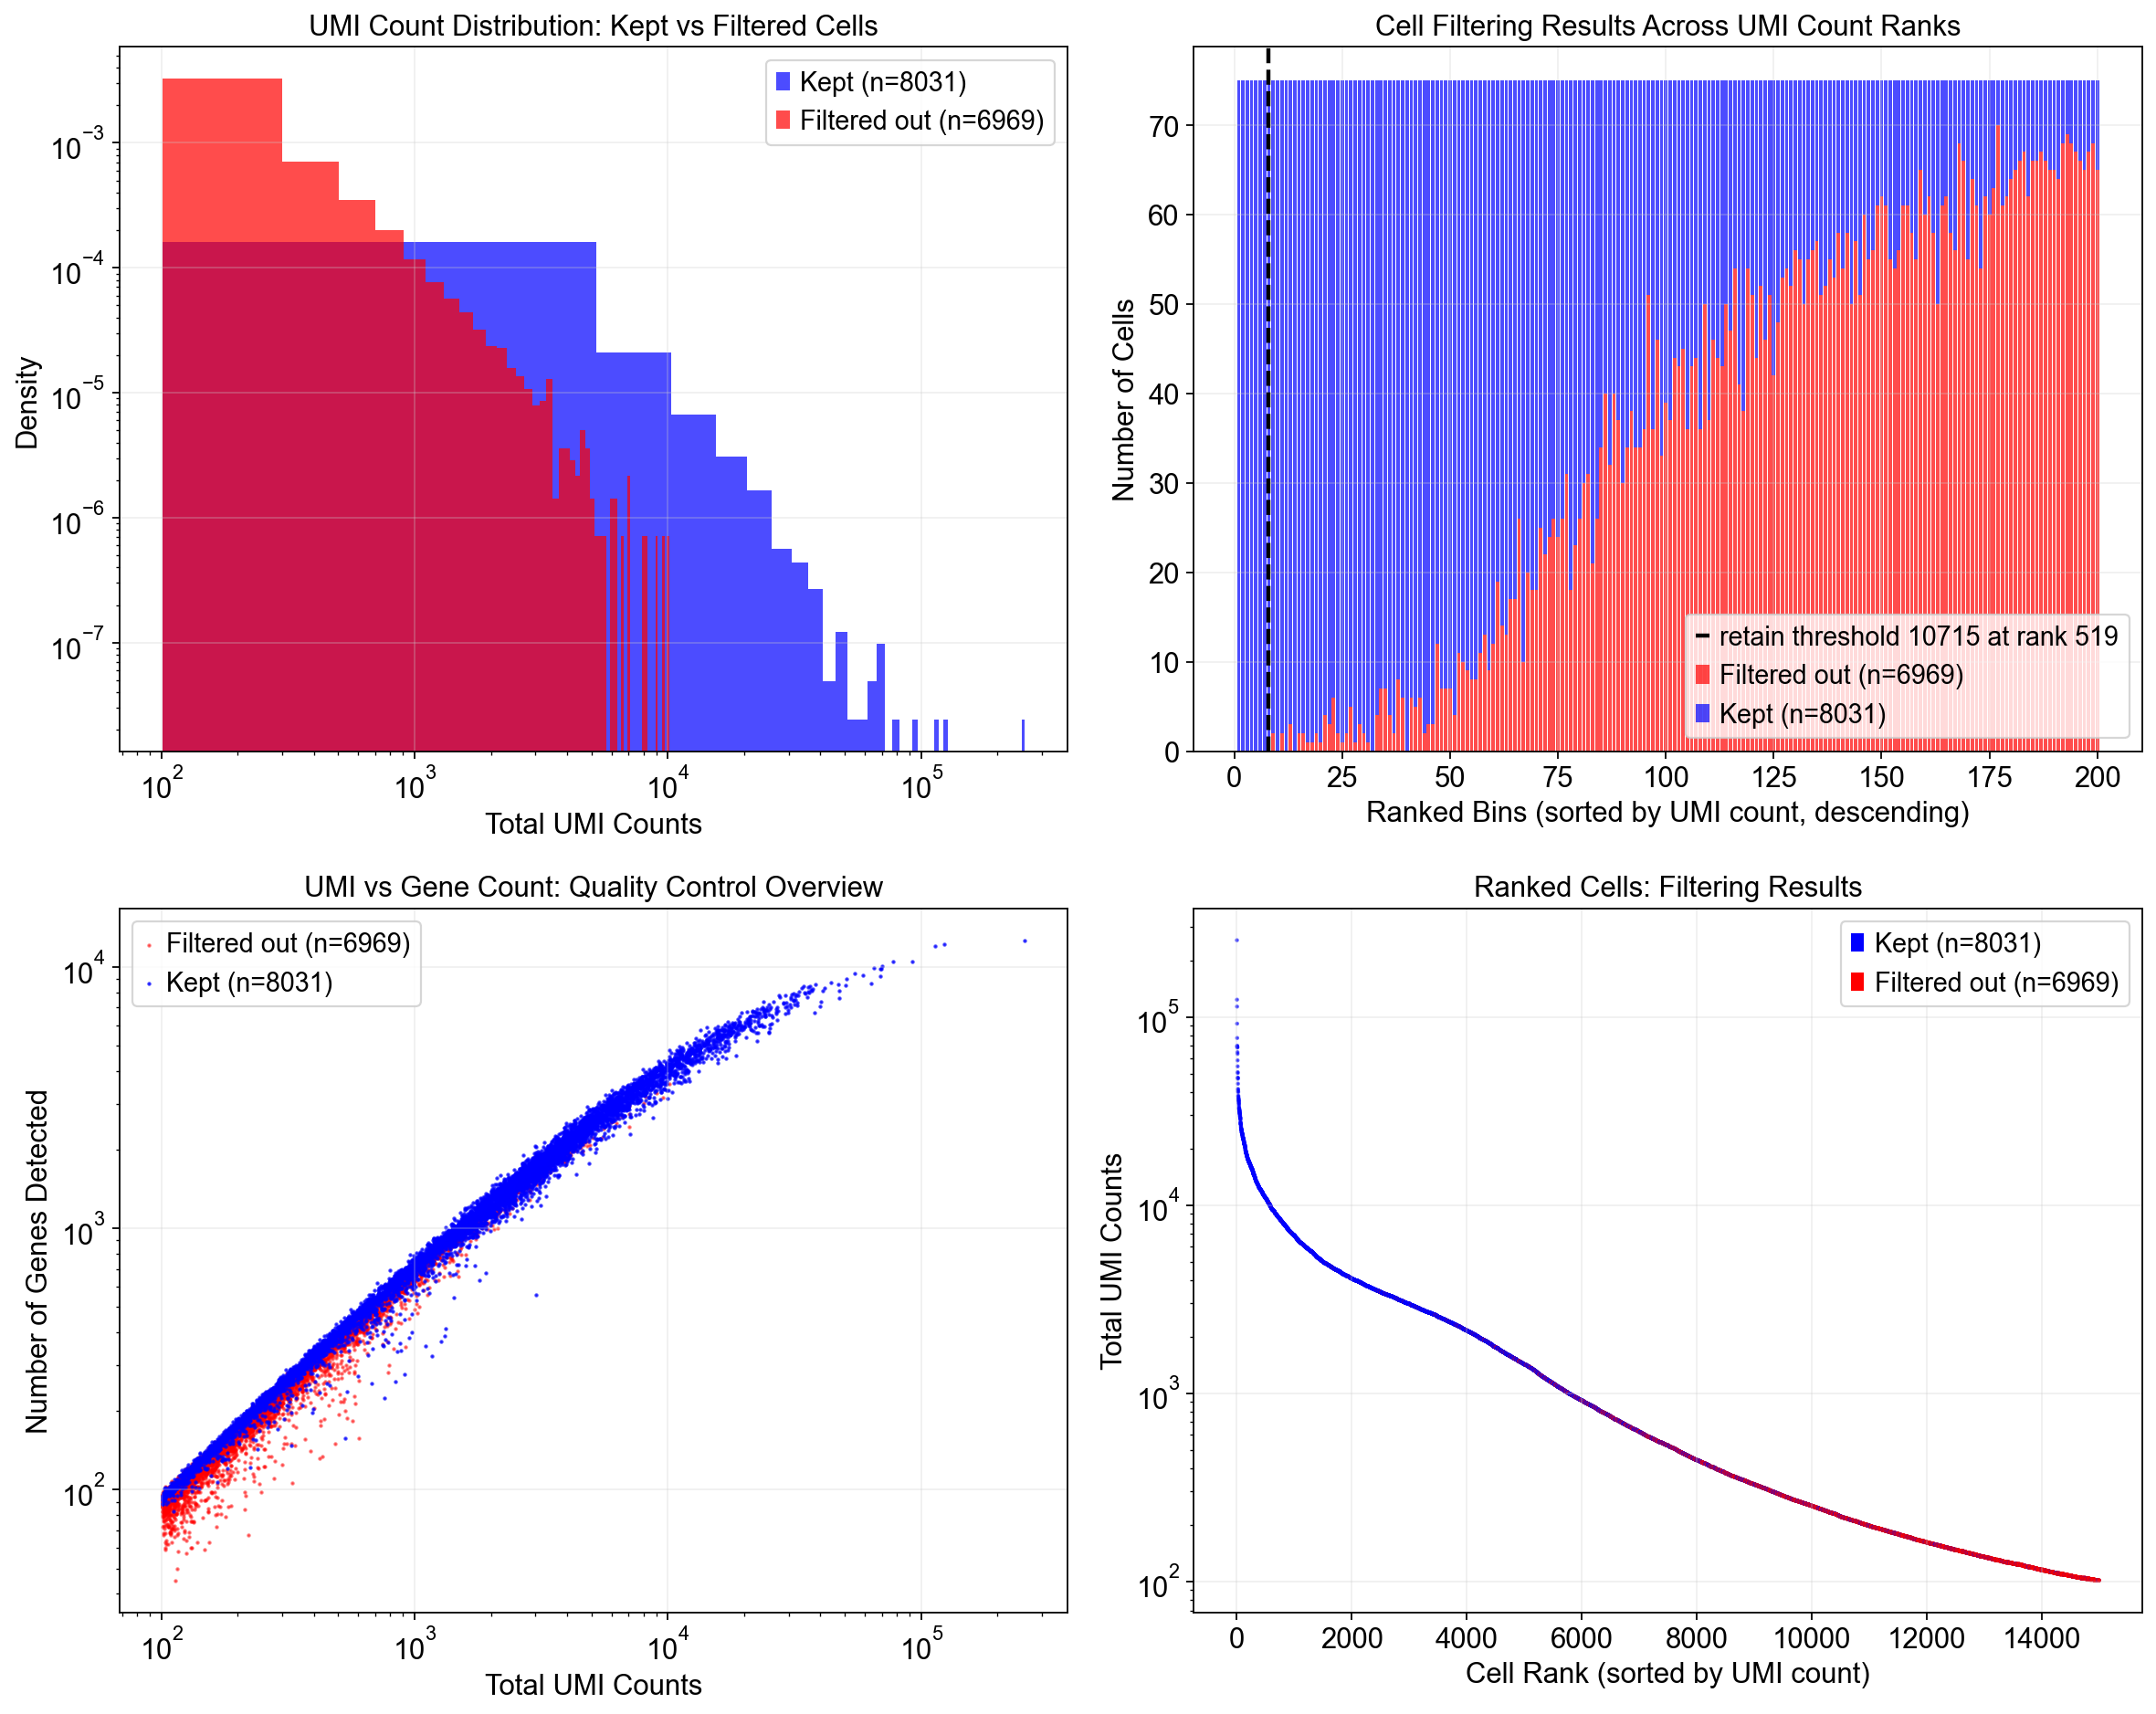


FILTERING SUMMARY:
Total cells (UMI > 100): 15,000
Cells kept after filtering: 8,031 (53.5%)
Cells filtered out: 6,969 (46.5%)

Kept cells statistics:
  UMI count - Mean: 3499, Median: 1987
  Gene count - Mean: 1564, Median: 1208

Filtered cells statistics:
  UMI count - Mean: 415, Median: 208
  Gene count - Mean: 281, Median: 168


In [ ]:
# Get cell indices that were kept in simple_adata
# The obs.index contains cell barcodes (strings), not integers
kept_cell_barcodes = set(simple_adata.obs.index)  # Convert to set for faster lookup
simple_bdata = raw_data_gex[raw_data_gex.X.sum(axis=1) > 100, :]
print(simple_bdata)

# map kept_cell_barcodes to simple_bdata
simple_bdata.obs['kept'] = simple_bdata.obs.index.isin(kept_cell_barcodes)

print(simple_bdata.obs['kept'])

# Create meaningful plots to showcase which cells were kept vs filtered
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Calculate UMI counts for plotting
if 'total_counts' in simple_bdata.obs.columns:
    umi_counts = simple_bdata.obs['total_counts'].values
else:
    umi_counts = np.array(simple_bdata.X.sum(axis=1)).flatten()

# Calculate gene counts
if 'n_genes_by_counts' in simple_bdata.obs.columns:
    gene_counts = simple_bdata.obs['n_genes_by_counts'].values
else:
    gene_counts = np.array((simple_bdata.X > 0).sum(axis=1)).flatten()

kept_mask = simple_bdata.obs['kept'].values
kept_counts = np.sum(kept_mask)
total_counts = len(kept_mask)

# Plot 1: UMI count distribution
axes[0, 0].hist(umi_counts[kept_mask], bins=50, alpha=0.7, color='blue', 
                label=f'Kept (n={kept_counts})', density=True)
axes[0, 0].hist(umi_counts[~kept_mask], bins=50, alpha=0.7, color='red', 
                label=f'Filtered out (n={total_counts - kept_counts})', density=True)
axes[0, 0].set_xlabel('Total UMI Counts')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('UMI Count Distribution: Kept vs Filtered Cells')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Ranked bins showing proportion of kept vs filtered cells
n_bins = 200

# Sort cells by UMI count (descending order)
sorted_indices = np.argsort(umi_counts)[::-1]
sorted_umi = umi_counts[sorted_indices]
sorted_kept = kept_mask[sorted_indices]

# Find the rank where UMI count drops to 10715 (threshold)
threshold_umi = 10715
threshold_rank = np.where(sorted_umi <= threshold_umi)[0]
if len(threshold_rank) > 0:
    threshold_rank = threshold_rank[0] + 1  # +1 for 1-based ranking
else:
    threshold_rank = len(sorted_umi)  # If all cells are above threshold

# Create bins based on ranked cells
cells_per_bin = len(sorted_umi) // n_bins
bin_edges = np.arange(0, len(sorted_umi) + cells_per_bin, cells_per_bin)
if bin_edges[-1] < len(sorted_umi):
    bin_edges = np.append(bin_edges, len(sorted_umi))

# Count kept and filtered cells in each ranked bin
kept_counts_per_bin = np.zeros(len(bin_edges) - 1)
filtered_counts_per_bin = np.zeros(len(bin_edges) - 1)

for i in range(len(bin_edges) - 1):
    start_idx = bin_edges[i]
    end_idx = bin_edges[i + 1]
    bin_kept = sorted_kept[start_idx:end_idx]
    
    kept_counts_per_bin[i] = np.sum(bin_kept)
    filtered_counts_per_bin[i] = np.sum(~bin_kept)

# Create bin centers for x-axis (ranked bin numbers)
bin_centers = np.arange(1, len(kept_counts_per_bin) + 1)
bin_width = 0.8

# Convert threshold rank to bin number
threshold_bin = (threshold_rank - 1) / cells_per_bin + 1

# Create stacked bar plot
axes[0, 1].bar(bin_centers, filtered_counts_per_bin, width=bin_width, 
               color='red', alpha=0.7, label=f'Filtered out (n={total_counts - kept_counts})')
axes[0, 1].bar(bin_centers, kept_counts_per_bin, bottom=filtered_counts_per_bin, 
               width=bin_width, color='blue', alpha=0.7, label=f'Kept (n={kept_counts})')

# Add vertical line at threshold
axes[0, 1].axvline(x=threshold_bin, color='black', linestyle='--', linewidth=2, 
                   label=f'retain threshold {threshold_umi} at rank {threshold_rank:,}')

axes[0, 1].set_xlabel('Ranked Bins (sorted by UMI count, descending)')
axes[0, 1].set_ylabel('Number of Cells')
axes[0, 1].set_title('Cell Filtering Results Across UMI Count Ranks')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot UMI vs Genes
axes[1, 0].scatter(umi_counts[~kept_mask], gene_counts[~kept_mask], 
                   alpha=0.5, s=1, color='red', label=f'Filtered out (n={total_counts - kept_counts})')
axes[1, 0].scatter(umi_counts[kept_mask], gene_counts[kept_mask], 
                   alpha=0.7, s=1, color='blue', label=f'Kept (n={kept_counts})')
axes[1, 0].set_xlabel('Total UMI Counts')
axes[1, 0].set_ylabel('Number of Genes Detected')
axes[1, 0].set_title('UMI vs Gene Count: Quality Control Overview')
axes[1, 0].legend()
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Ranked cells by UMI count showing filtering
sorted_indices = np.argsort(umi_counts)[::-1]
sorted_umi = umi_counts[sorted_indices]
sorted_kept = kept_mask[sorted_indices]
cell_ranks = np.arange(1, len(sorted_umi) + 1)

# Color cells by kept status
colors = ['blue' if kept else 'red' for kept in sorted_kept]
axes[1, 1].scatter(cell_ranks, sorted_umi, c=colors, alpha=0.6, s=1)
axes[1, 1].set_xlabel('Cell Rank (sorted by UMI count)')
axes[1, 1].set_ylabel('Total UMI Counts')
axes[1, 1].set_title('Ranked Cells: Filtering Results')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# Add custom legend for the scatter plot
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label=f'Kept (n={kept_counts})'),
                   Patch(facecolor='red', label=f'Filtered out (n={total_counts - kept_counts})')]
axes[1, 1].legend(handles=legend_elements)

plt.tight_layout()
# save the plot
if niters == 500:
    plt.savefig('niters500_cell_filtering_results.png', dpi=300, bbox_inches='tight')
elif niters == 10000:
    plt.savefig('niters10000_cell_filtering_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\nFILTERING SUMMARY:")
print(f"{'='*50}")
print(f"Total cells (UMI > 100): {total_counts:,}")
print(f"Cells kept after filtering: {kept_counts:,} ({kept_counts/total_counts*100:.1f}%)")
print(f"Cells filtered out: {total_counts - kept_counts:,} ({(total_counts - kept_counts)/total_counts*100:.1f}%)")
print(f"\nKept cells statistics:")
print(f"  UMI count - Mean: {umi_counts[kept_mask].mean():.0f}, Median: {np.median(umi_counts[kept_mask]):.0f}")
print(f"  Gene count - Mean: {gene_counts[kept_mask].mean():.0f}, Median: {np.median(gene_counts[kept_mask]):.0f}")
print(f"\nFiltered cells statistics:")
print(f"  UMI count - Mean: {umi_counts[~kept_mask].mean():.0f}, Median: {np.median(umi_counts[~kept_mask]):.0f}")
print(f"  Gene count - Mean: {gene_counts[~kept_mask].mean():.0f}, Median: {np.median(gene_counts[~kept_mask]):.0f}")